In [1]:
%matplotlib widget

import numpy as np
import scipy
import matplotlib.pyplot as plt

from receiver import Receiver802154
from filters import simple_squelch, add_white_gaussian_noise, decimating_fir_filter
from demodulation import demodulate_frequency, symbol_sync, binary_slicer
from data_io import read_iq_data
from visualisation import plot_complex_time, plot_periodograms, plot_payload
from modulation import gaussian_fir_taps

plt.close('all')

# Testing matched filtering on demodulation process

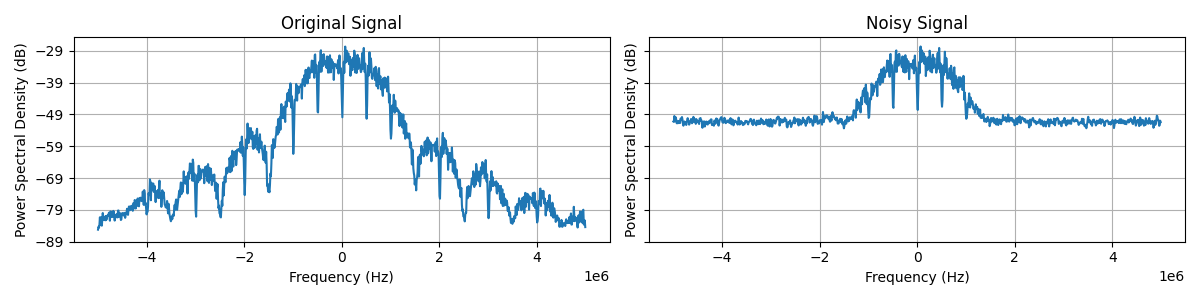

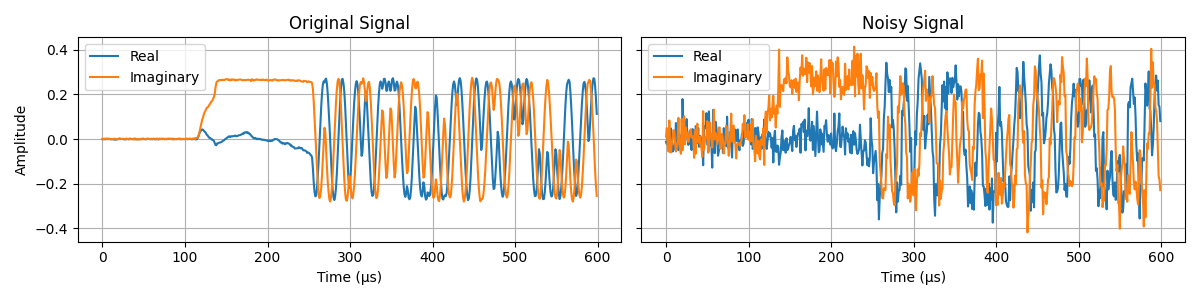

In [8]:
fs = 10e6  # Hz
sps = 5  # Samples per chip, 2 Mchip/s, but 1 Msym/s QPSK
filename = "802154_0dBm.dat"  # Open BLE file
iq_samples = read_iq_data(f"../capture_nRF/data/new/{filename}")
fsk_deviation_802154: float = 500e3  # Hz, when interpreting HSS O-QPSK as MSK

noise_power = -20
iq_samples_noisy = add_white_gaussian_noise(iq_samples, noise_power)

figsize = (12, 3)
plot_periodograms(
    [iq_samples, iq_samples_noisy],
    fs=fs,
    titles=["Original Signal", "Noisy Signal"],
    figsize=figsize,
    NFFT=1024,
    horizontal=True,
)
time_interval = (6800, 7400)
plot_complex_time(
    [iq_samples[time_interval[0] : time_interval[1]], iq_samples_noisy[time_interval[0] : time_interval[1]]],
    fs=fs,
    titles=["Original Signal", "Noisy Signal"],
    figsize=figsize,
    horizontal=True,
)

## Demodulation process at receiver
Applying matched filtering before frequency demodulating yields better results

## Band-pass Based Matched Filtering

Apply band-pass matched filtering to the expected frequency at binary 1 and the expected frequency at binary 0 (centre frequency $ \pm \Delta_{FSK} = 500$ kHz). Compare the squared magnitudes of the resulting complex convolution for soft decision-making.

Based on:  
- [FSK Signals Demodulation – WJ Tech Notes](https://www.rfcafe.com/references/articles/wj-tech-notes/fsk-signals-demodulation-v7-5.pdf)  
- [FSK Demodulation & Bit Timing Recovery – DSP Stack Exchange](https://dsp.stackexchange.com/questions/30793/fsk-demodulation-bit-timing-recovery)  

